In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 

mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [2]:
files_ele = os.listdir("/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v4_training/")

In [3]:
print(f"N ele files: {len(files_ele)}")

N ele files: 51


In [4]:
datas = []

for i in range(1, 51):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v4_training/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas += [insc, outsc]
    
data = pd.concat(datas, ignore_index=True)
data["particle"] = "electron"



In [21]:
datas_test = []

for i in range(1, 51):
    f = f"/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v4_test/clusters_data_{i}.pkl"
    if not os.path.exists(f):
        print("file not found: ", f)
        continue
    d = pickle.load(open(f, "rb"))
    outsc = d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == False)]
    insc =  d[(d.is_calo) & (d.is_seed == False) & (d.in_scluster == True)]    
    outsc = outsc.iloc[:len(insc)*5]
    datas_test += [insc, outsc]
    
data_test = pd.concat(datas_test, ignore_index=True)


file not found:  /eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v4_test/clusters_data_2.pkl
file not found:  /eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v4_test/clusters_data_3.pkl


Balance gamma and electron

In [5]:
print("N in supercluster: ", len(data[data.in_scluster]))
print("N out supercluster: ", len(data[(data.in_scluster == False)]))

N in supercluster:  268647
N out supercluster:  1343235


## Check plots

(array([[1.46486314, 1.61134946, 2.19729471, ..., 0.73243157, 0.87891788,
         0.87891788],
        [1.31837683, 0.87891788, 0.87891788, ..., 0.73243157, 1.46486314,
         1.17189051],
        [1.61134946, 1.0254042 , 1.17189051, ..., 0.87891788, 0.87891788,
         1.75783577],
        ...,
        [1.46486314, 0.29297263, 0.87891788, ..., 0.73243157, 1.46486314,
         1.31837683],
        [1.0254042 , 1.46486314, 1.17189051, ..., 2.0508084 , 1.61134946,
         1.31837683],
        [1.17189051, 0.43945894, 1.17189051, ..., 0.58594526, 1.31837683,
         1.61134946]]),
 array([-6.99989200e-01, -6.85989407e-01, -6.71989615e-01, -6.57989823e-01,
        -6.43990030e-01, -6.29990238e-01, -6.15990446e-01, -6.01990653e-01,
        -5.87990861e-01, -5.73991069e-01, -5.59991276e-01, -5.45991484e-01,
        -5.31991692e-01, -5.17991899e-01, -5.03992107e-01, -4.89992315e-01,
        -4.75992522e-01, -4.61992730e-01, -4.47992938e-01, -4.33993145e-01,
        -4.19993353e-01, -4.0

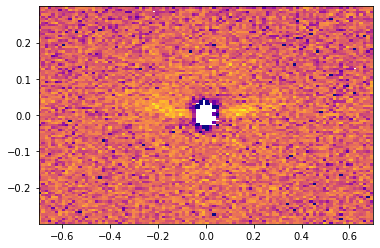

In [6]:
plt.hist2d(outsc.cluster_dphi, outsc.cluster_deta, 
           density=True, bins=(100,100),cmap="plasma", norm=colors.LogNorm())

## Weights by DeltaPhi

In [6]:
cols = ["seed_eta", "seed_phi", "seed_iz","cluster_deta", "cluster_dphi", "en_seed", "en_cluster", 
       "f5_r9", "f5_sigmaIetaIeta","f5_sigmaIetaIphi","f5_sigmaIphiIphi","swissCross", "nxtals"]

In [7]:
X = data[ cols ].values
truth = data[["in_scluster", "nclusters"]].values
y = np.array(truth[:,0], dtype=int)
#train_weights = data.train_weight.values

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open("../models/v3_newscore/scaler_model1.pkl", "wb"))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25)

In [22]:
X_test = data_test[ cols ].values
truth_test = data_test[["in_scluster", "nclusters"]].values
y_test = np.array(truth_test[:,0], dtype=int)

X_test =  scaler.transform(X_test)

In [16]:
from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler
training_generator, steps_per_epoch_train = balanced_batch_generator(X_train, y_train,  batch_size=1024, sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val = balanced_batch_generator(X_val, y_val, batch_size=1024, sampler=RandomOverSampler())

# Training

In [17]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

In [18]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1400      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                4050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total para

In [19]:
auto_save = ModelCheckpoint("../models/v3_newscore/model1_newscore_100_80_50.hd5", monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=5)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
                            patience=15, verbose=1)

history = model.fit_generator(
            training_generator, 
            epochs=100,
            steps_per_epoch=steps_per_epoch_train, 
            validation_data = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks = [early_stop, auto_save]
            )

Epoch 1/100
1967/1967 [==============================] - 13s 7ms/step - loss: 0.0764 - acc: 0.9740 - val_loss: 0.0468 - val_acc: 0.9842
Epoch 2/100
1967/1967 [==============================] - 13s 6ms/step - loss: 0.0489 - acc: 0.9836 - val_loss: 0.0432 - val_acc: 0.9856
Epoch 3/100
1967/1967 [==============================] - 12s 6ms/step - loss: 0.0462 - acc: 0.9847 - val_loss: 0.0424 - val_acc: 0.9859
Epoch 4/100
1967/1967 [==============================] - 13s 6ms/step - loss: 0.0450 - acc: 0.9851 - val_loss: 0.0413 - val_acc: 0.9862
Epoch 5/100
1967/1967 [==============================] - 12s 6ms/step - loss: 0.0442 - acc: 0.9854 - val_loss: 0.0411 - val_acc: 0.9863

Epoch 00005: val_loss improved from inf to 0.04110, saving model to ../models/v3_newscore/model1_newscore_100_80_50.hd5
Epoch 6/100
1967/1967 [==============================] - 13s 6ms/step - loss: 0.0436 - acc: 0.9855 - val_loss: 0.0407 - val_acc: 0.9864
Epoch 7/100
1967/1967 [==============================] - 12s 6m

In [ ]:
model.save("../models/model1_showervars_100_80_50.hd5")

In [ ]:
history = model.fit(
            x = X_train, y = y_train, 
            epochs=200,
            batch_size = 1024, 
            shuffle=True, 
            validation_split=0.15, 
            callbacks = [auto_save, early_stop]
            )

>>> Computing AUC...
AUC score: 0.9986067059261274
>>> Saving ROC curve...


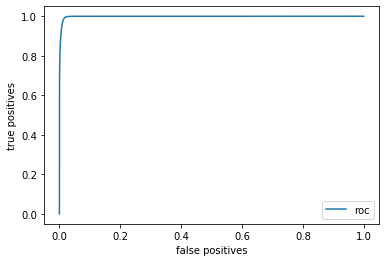

In [23]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_test,batch_size=2048)
auc = roc_auc_score(y_test, pred)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_test, pred)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)
plt.legend()

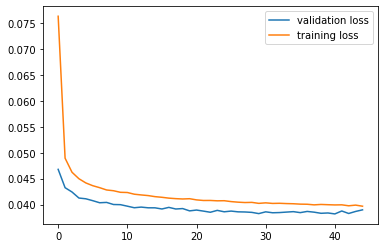

In [24]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

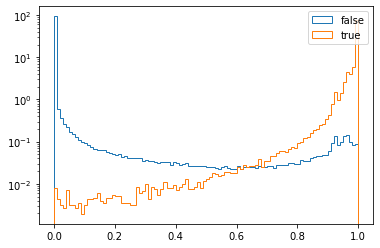

In [25]:
results = model.predict(X_test)
plt.hist(results[y_test==0], bins=100,density=True, label="false", histtype="step")
plt.hist(results[y_test==1], bins=100, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

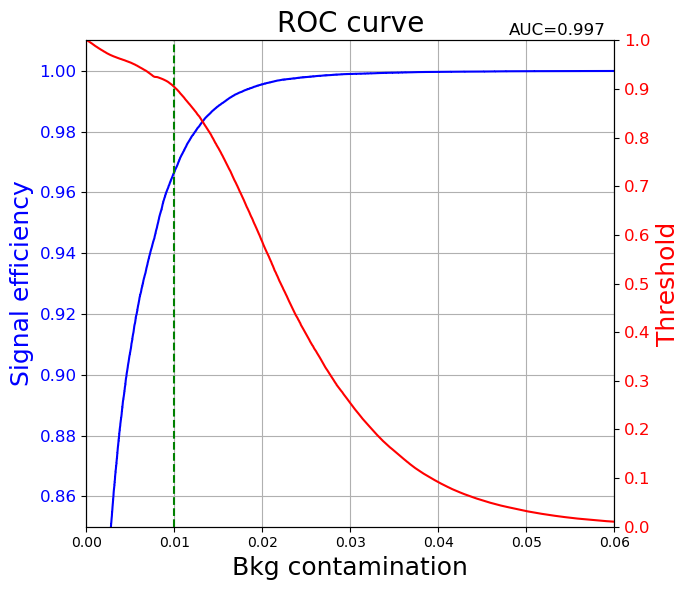

In [26]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

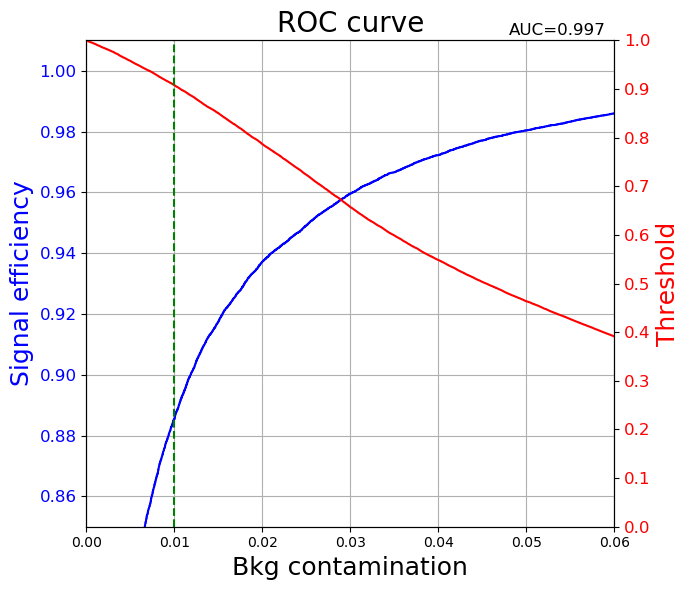

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()